In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATASET_ROOT = "/content/drive/My Drive/Goslar_dataset"
IMG_EXT = ".png"


# **Count Images Per Class (Check Imbalance)**

In [ ]:
class_counts = {}

for cls in sorted(os.listdir(DATASET_ROOT)):
    cls_path = os.path.join(DATASET_ROOT, cls)
    if os.path.isdir(cls_path):
        class_counts[cls] = len([
            f for f in os.listdir(cls_path)
            if f.endswith(IMG_EXT)
        ])

df_counts = pd.DataFrame.from_dict(
    class_counts, orient="index", columns=["Image_Count"]
)
df_counts


Image_Count
0          502
1         1215
2          420
3          211

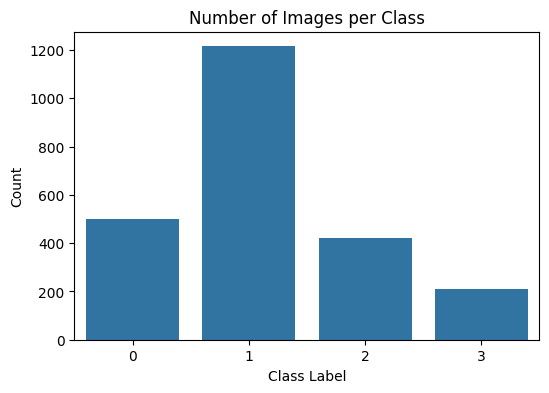

In [ ]:
plt.figure(figsize=(6,4))
sns.barplot(x=df_counts.index, y=df_counts["Image_Count"])
plt.title("Number of Images per Class")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.show()


# **Visualize Random Samples per Class**

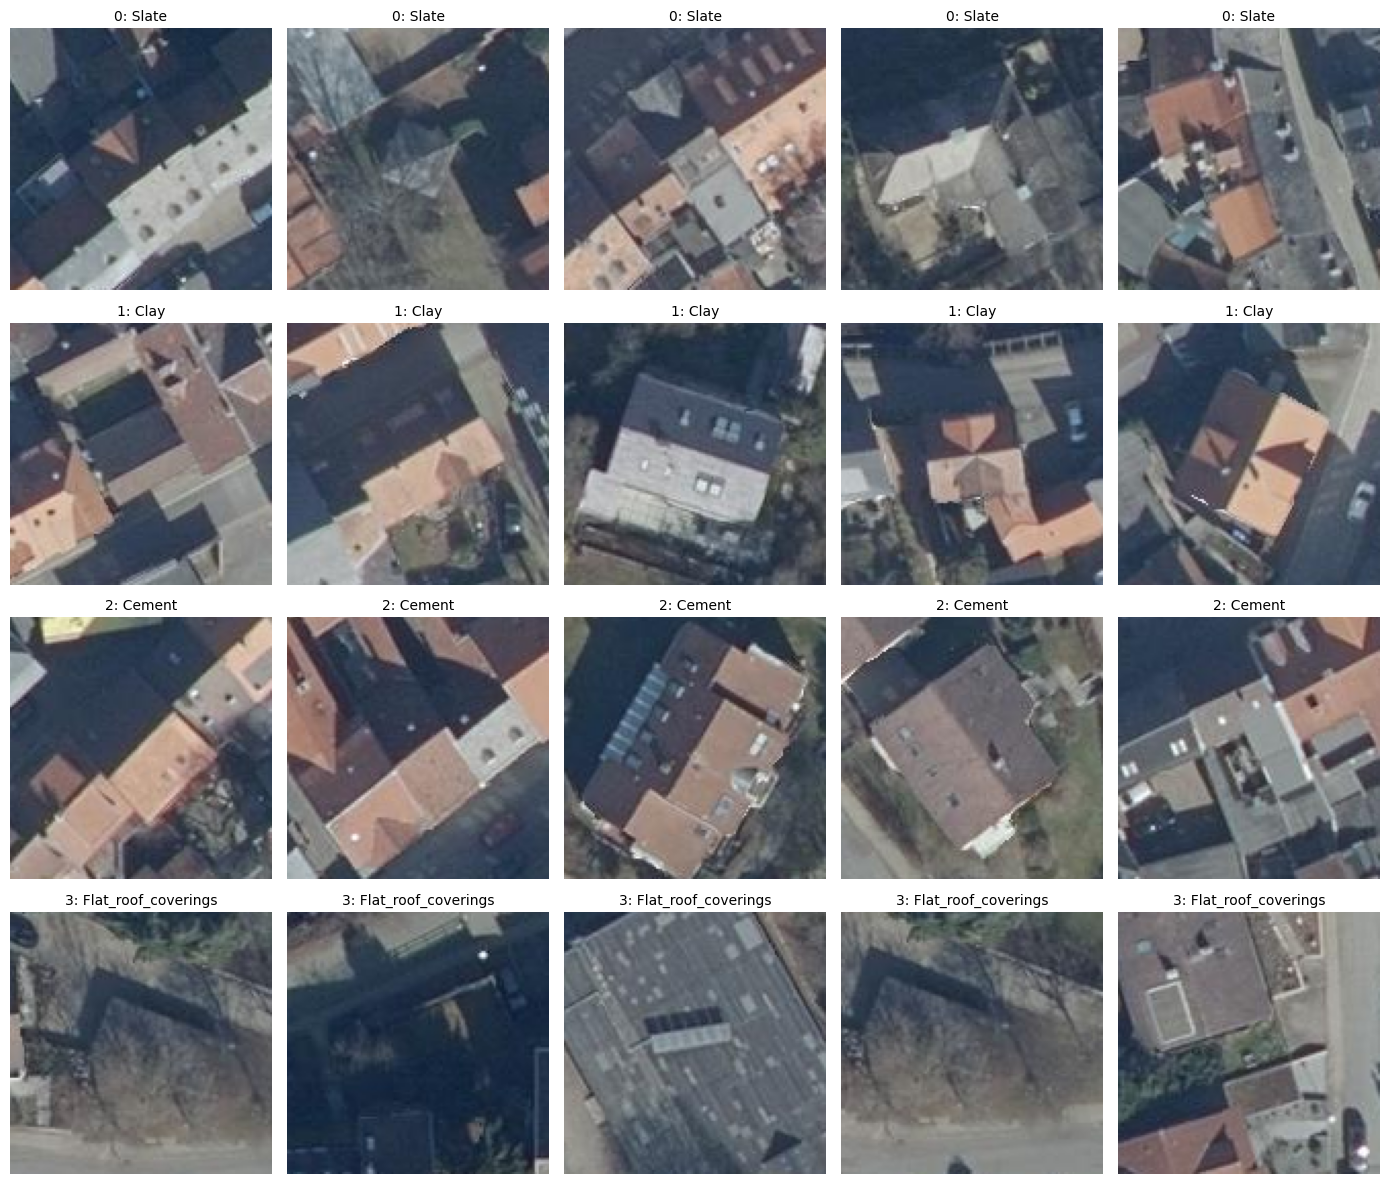

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

labels = ['Slate', 'Clay', 'Cement', 'Flat_roof_coverings']

def show_samples_per_class(n=5):
    classes = sorted([
        c for c in os.listdir(DATASET_ROOT)
        if os.path.isdir(os.path.join(DATASET_ROOT, c))
    ])

    plt.figure(figsize=(14, 3 * len(classes)))
    idx = 1

    for cls in classes:
        cls_path = os.path.join(DATASET_ROOT, cls)
        images = os.listdir(cls_path)

        selected = np.random.choice(images, n, replace=False)

        for img in selected:
            img_path = os.path.join(cls_path, img)
            image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

            plt.subplot(len(classes), n, idx)
            plt.imshow(image)
            plt.axis("off")

            class_idx = int(cls)
            plt.title(
                f"{class_idx}: {labels[class_idx]}",
                fontsize=10
            )

            idx += 1  # ✅ always increment

    plt.tight_layout()
    plt.show()

# Run
show_samples_per_class(n=5)


# **Image Size Consistency Check**

In [ ]:
sizes = []

for cls in os.listdir(DATASET_ROOT):
    cls_path = os.path.join(DATASET_ROOT, cls)
    for img in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img)
        image = cv2.imread(img_path)
        h, w, _ = image.shape
        sizes.append([cls, h, w])

df_sizes = pd.DataFrame(sizes, columns=["Class", "Height", "Width"])
df_sizes.describe()


Height   Width
count  2348.0  2348.0
mean    128.0   128.0
std       0.0     0.0
min     128.0   128.0
25%     128.0   128.0
50%     128.0   128.0
75%     128.0   128.0
max     128.0   128.0

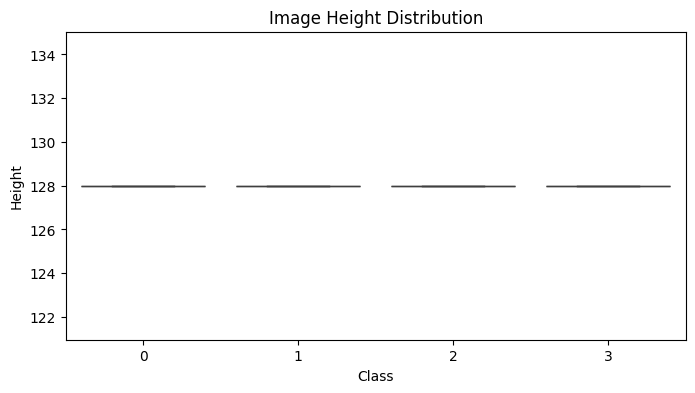

In [ ]:
plt.figure(figsize=(8,4))
sns.boxplot(data=df_sizes, x="Class", y="Height")
plt.title("Image Height Distribution")
plt.show()


# **Brightness & Contrast Analysis**

In [ ]:
brightness = []

for cls in os.listdir(DATASET_ROOT):
    cls_path = os.path.join(DATASET_ROOT, cls)
    for img in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img)
        gray = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2GRAY)
        brightness.append([
            cls,
            gray.mean(),
            gray.std()
        ])

df_bc = pd.DataFrame(
    brightness, columns=["Class", "Brightness", "Contrast"]
)


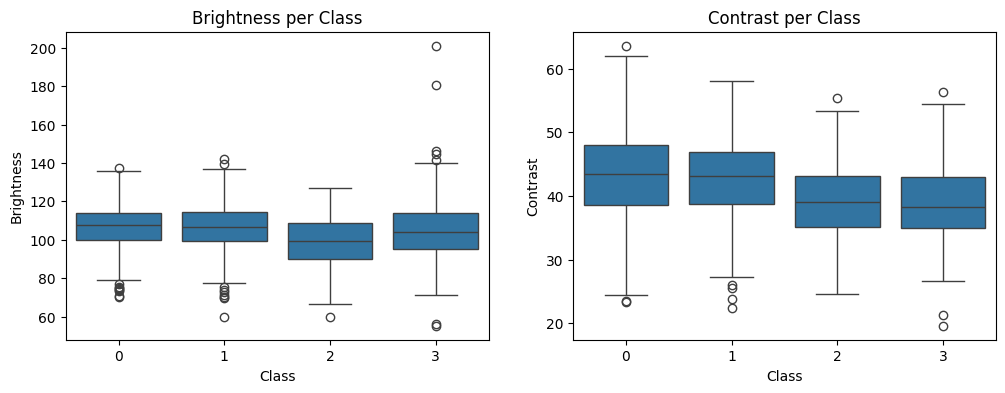

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.boxplot(x="Class", y="Brightness", data=df_bc)
plt.title("Brightness per Class")

plt.subplot(1,2,2)
sns.boxplot(x="Class", y="Contrast", data=df_bc)
plt.title("Contrast per Class")

plt.show()


# **RGB Channel Distribution**

In [ ]:
rgb_stats = []

for cls in os.listdir(DATASET_ROOT):
    cls_path = os.path.join(DATASET_ROOT, cls)
    for img in os.listdir(cls_path):
        image = cv2.cvtColor(
            cv2.imread(os.path.join(cls_path, img)),
            cv2.COLOR_BGR2RGB
        )
        rgb_stats.append([
            cls,
            image[:,:,0].mean(),
            image[:,:,1].mean(),
            image[:,:,2].mean()
        ])

df_rgb = pd.DataFrame(
    rgb_stats, columns=["Class", "R", "G", "B"]
)


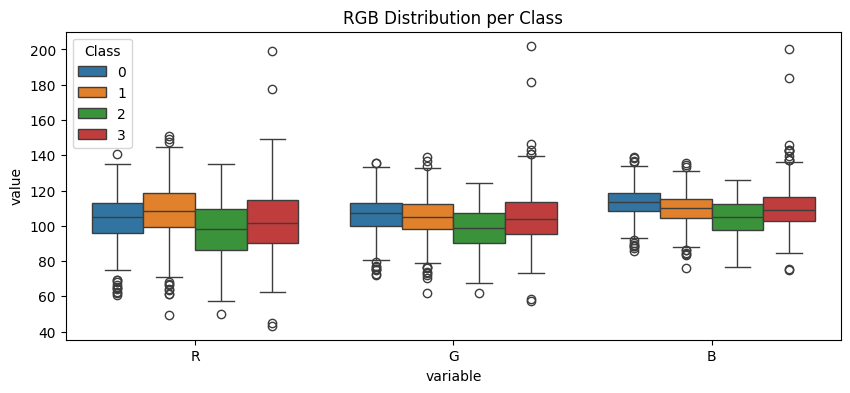

In [ ]:
plt.figure(figsize=(10,4))
sns.boxplot(
    data=df_rgb.melt(id_vars="Class"),
    x="variable",
    y="value",
    hue="Class"
)
plt.title("RGB Distribution per Class")
plt.show()


# **Edge Density (Texture Strength)**

In [ ]:
edge_density = []

for cls in os.listdir(DATASET_ROOT):
    cls_path = os.path.join(DATASET_ROOT, cls)
    for img in os.listdir(cls_path):
        gray = cv2.cvtColor(
            cv2.imread(os.path.join(cls_path, img)),
            cv2.COLOR_BGR2GRAY
        )
        edges = cv2.Canny(gray, 100, 200)
        edge_density.append([cls, edges.mean()])

df_edges = pd.DataFrame(edge_density, columns=["Class", "EdgeDensity"])


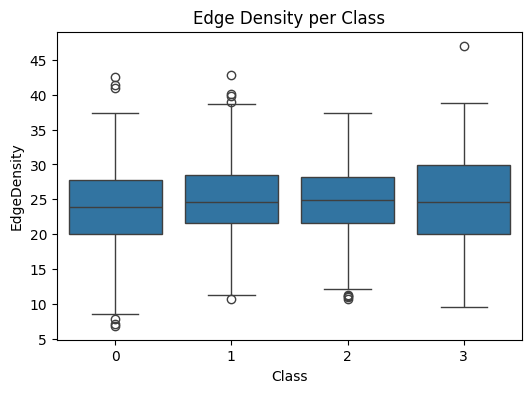

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(x="Class", y="EdgeDensity", data=df_edges)
plt.title("Edge Density per Class")
plt.show()


# **Identify Outliers (Bad Samples)**

In [ ]:
df_bc["Brightness_z"] = (
    df_bc["Brightness"] - df_bc["Brightness"].mean()
) / df_bc["Brightness"].std()

outliers = df_bc[np.abs(df_bc["Brightness_z"]) > 2.5]
outliers.head()


Class  Brightness   Contrast  Brightness_z
22      0  137.351318  44.010441      2.551047
79      0   73.238281  28.487998     -2.539042
142     0   70.672119  29.651976     -2.742776
501     0   70.431702  24.519829     -2.761863
512     1   69.869324  32.506491     -2.806512

In [ ]:
outliers

Class  Brightness   Contrast  Brightness_z
22       0  137.351318  44.010441      2.551047
79       0   73.238281  28.487998     -2.539042
142      0   70.672119  29.651976     -2.742776
501      0   70.431702  24.519829     -2.761863
512      1   69.869324  32.506491     -2.806512
583      1   71.148193  32.694617     -2.704979
852      1   70.219788  27.491118     -2.778688
899      1  142.131653  33.517757      2.930570
1003     1  139.664246  42.844804      2.734676
1351     1   59.628906  25.966404     -3.619523
1469     1   72.626160  32.385417     -2.587640
1629     1  136.790222  32.948222      2.506500
1785     2   67.402771  25.522376     -3.002337
1798     2   70.809875  41.092149     -2.731839
1799     2   72.612183  31.288367     -2.588750
1805     2   71.632568  30.932248     -2.666524
1851     2   67.804504  30.609123     -2.970443
1857     2   69.258179  30.988844     -2.855032
1858     2   68.449219  27.235038     -2.919257
1862     2   70.093140  28.393738     -2.788742
1865     2   59.936829  27.511458     -3.595077
1866     2   66.322754  25.529671     -3.088083
1870     2   73.472961  26.832627     -2.520410
2145     3  139.707520  41.822231      2.738112
2155     3  144.770081  48.362100      3.140041
2183     3   73.360413  19.622553     -2.529346
2200     3  138.660645  56.340695      2.654998
2217     3   55.236145  26.787313     -3.968275
2218     3   56.357300  28.598188     -3.879264
2242     3  137.856995  42.187240      2.591194
2258     3   71.140381  31.868969     -2.705599
2280     3  138.567688  46.685014      2.647618
2281     3  146.023010  29.347725      3.239514
2316     3  180.596924  50.615412      5.984421
2328     3  139.965820  35.547235      2.758619
2330     3  201.032715  33.389520      7.606868
2339     3  141.587280  51.831407      2.887351

# **Augmentation Sanity Check**

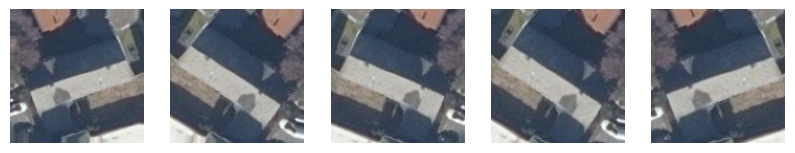

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

cls = "0"
img_path = os.path.join(
    DATASET_ROOT, cls,
    os.listdir(os.path.join(DATASET_ROOT, cls))[0]
)

img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
img = np.expand_dims(img, 0)

aug_iter = datagen.flow(img, batch_size=1)

plt.figure(figsize=(10,2))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(next(aug_iter)[0].astype("uint8"))
    plt.axis("off")
plt.show()


# **Basic Dataset Statistics (Class Distribution)**

In [ ]:
import os
import pandas as pd

DATASET_ROOT = "/content/drive/My Drive/Goslar_dataset_split"

splits = ["train", "val", "test"]
data = []

for split in splits:
    split_path = os.path.join(DATASET_ROOT, split)
    for cls in sorted(os.listdir(split_path)):
        cls_path = os.path.join(split_path, cls)
        if os.path.isdir(cls_path):
            count = len([
                f for f in os.listdir(cls_path)
                if f.endswith(".png")
            ])
            data.append([split, cls, count])

df = pd.DataFrame(data, columns=["Split", "Class", "Count"])
df


Split Class  Count
0   train     0    480
1   train     1    480
2   train     2    480
3   train     3    480
4     val     0     60
5     val     1     60
6     val     2     60
7     val     3     60
8    test     0     60
9    test     1     60
10   test     2     60
11   test     3     60

# **Visualize Class Distribution**

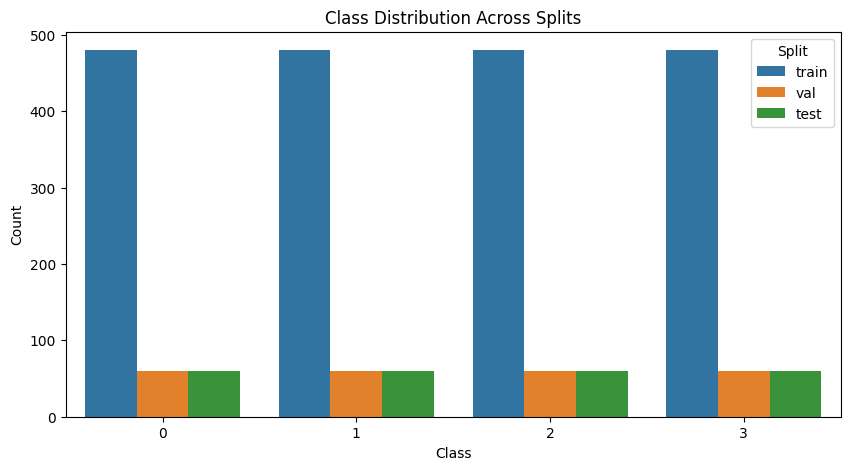

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.barplot(data=df, x="Class", y="Count", hue="Split")
plt.title("Class Distribution Across Splits")
plt.show()


# **Sample Image Visualization (Per Class)**

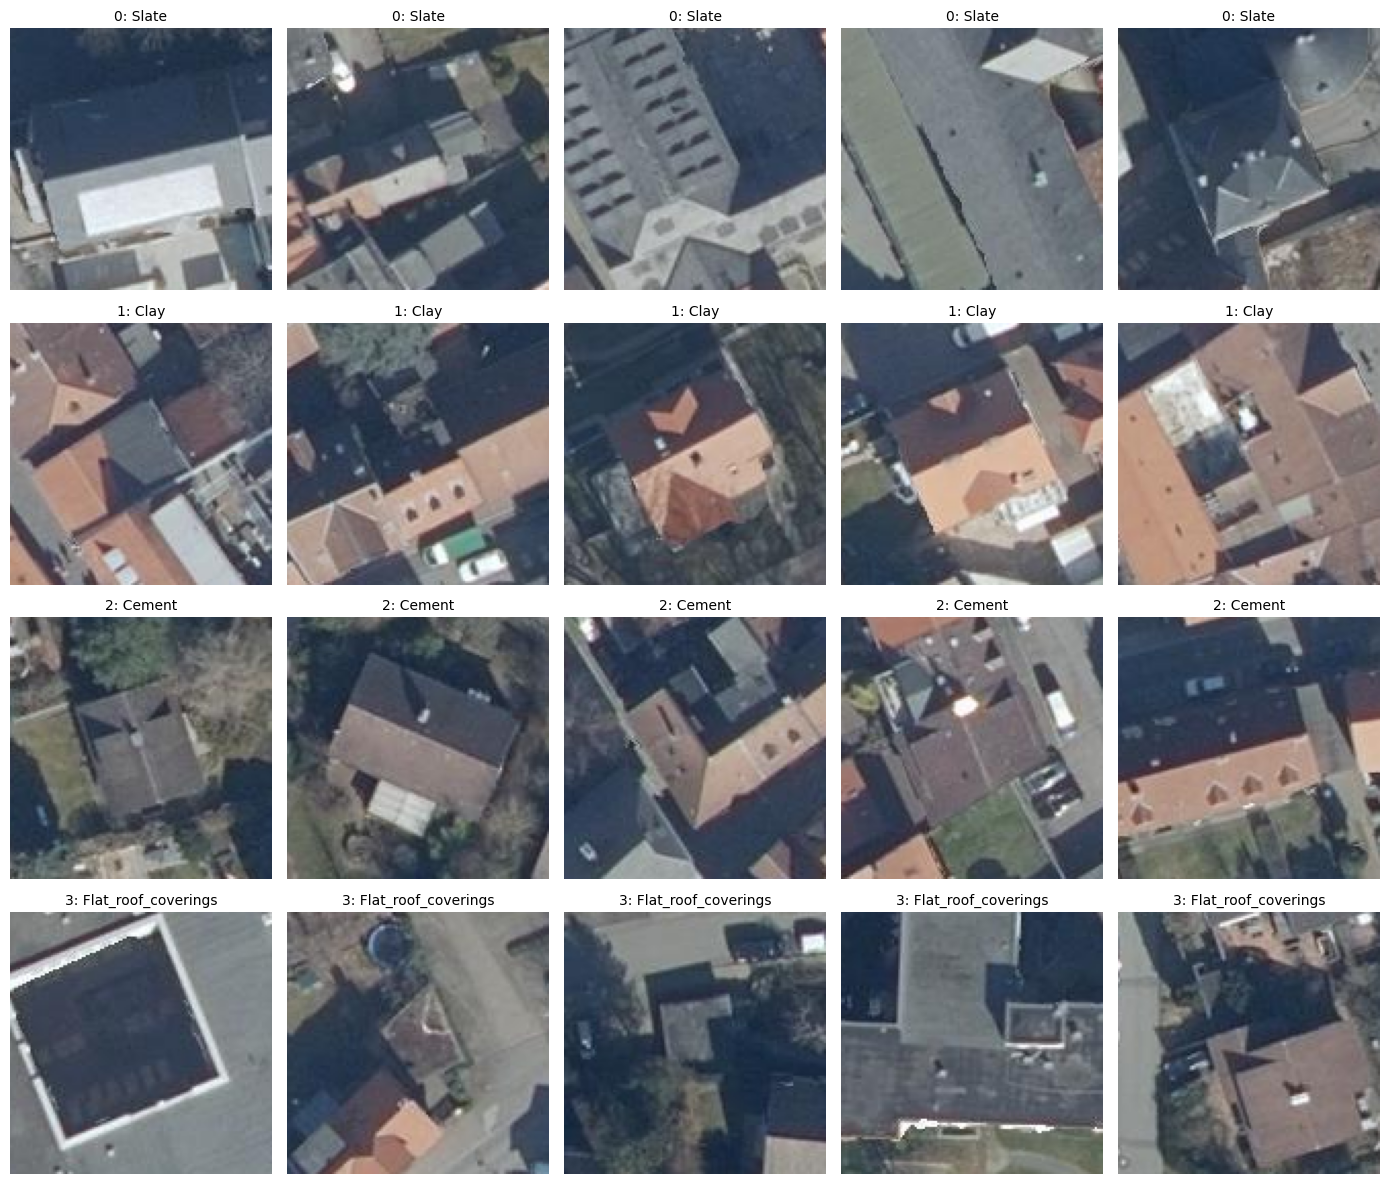

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

labels = ['Slate', 'Clay', 'Cement', 'Flat_roof_coverings']

def show_sample_images(split="train", n=5):
    class_dirs = sorted(os.listdir(os.path.join(DATASET_ROOT, split)))

    plt.figure(figsize=(14, 3 * len(class_dirs)))
    idx = 1

    for cls in class_dirs:
        cls_dir = os.path.join(DATASET_ROOT, split, cls)
        images = os.listdir(cls_dir)[:n]

        for img in images:
            img_path = os.path.join(cls_dir, img)
            image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

            plt.subplot(len(class_dirs), n, idx)
            plt.imshow(image)
            plt.axis("off")

            class_idx = int(cls)
            plt.title(
                f"{class_idx}: {labels[class_idx]}",
                fontsize=10
            )

            idx += 1

    plt.tight_layout()
    plt.show()

# Run
show_sample_images("train", 5)


# **Taking the Sample from Train set after division of dataset**

# **Image Brightness & Contrast Analysis**

In [ ]:
def brightness_contrast_stats(split="train"):
    stats = []

    for cls in sorted(os.listdir(os.path.join(DATASET_ROOT, split))):
        cls_dir = os.path.join(DATASET_ROOT, split, cls)
        for img in os.listdir(cls_dir):
            img_path = os.path.join(cls_dir, img)
            image = cv2.imread(img_path)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            stats.append([
                cls,
                gray.mean(),      # brightness
                gray.std()        # contrast
            ])

    return pd.DataFrame(stats, columns=["Class", "Brightness", "Contrast"])

df_stats = brightness_contrast_stats("train")
df_stats.head()


Class  Brightness   Contrast
0     0  109.773987  60.394848
1     0   93.704407  40.482936
2     0  111.279419  37.789046
3     0  124.321777  26.256735
4     0   88.108276  35.774904

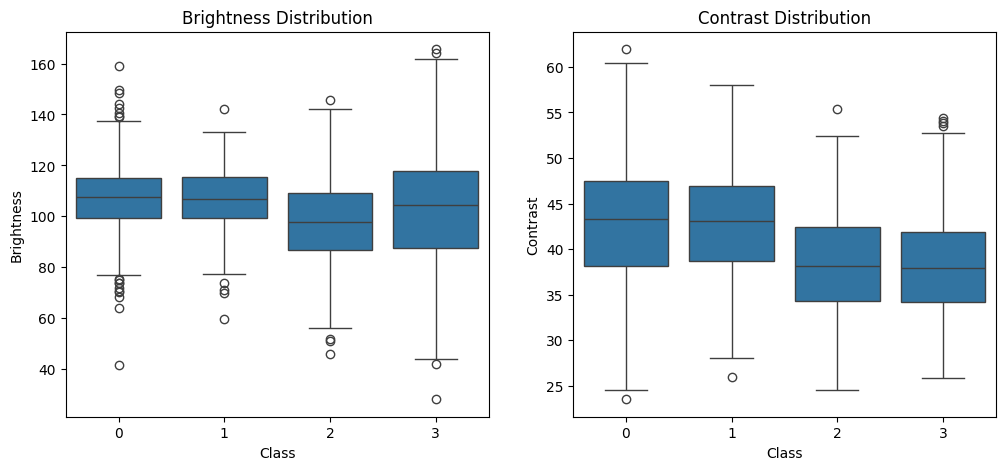

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.boxplot(x="Class", y="Brightness", data=df_stats)
plt.title("Brightness Distribution")

plt.subplot(1,2,2)
sns.boxplot(x="Class", y="Contrast", data=df_stats)
plt.title("Contrast Distribution")

plt.show()


# **Color Channel Distribution (RGB Bias)**

In [ ]:
def color_distribution(split="train"):
    records = []

    for cls in sorted(os.listdir(os.path.join(DATASET_ROOT, split))):
        cls_dir = os.path.join(DATASET_ROOT, split, cls)
        for img in os.listdir(cls_dir):
            img_path = os.path.join(cls_dir, img)
            image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
            r, g, b = image[:,:,0].mean(), image[:,:,1].mean(), image[:,:,2].mean()
            records.append([cls, r, g, b])

    return pd.DataFrame(records, columns=["Class", "R", "G", "B"])

df_color = color_distribution("train")


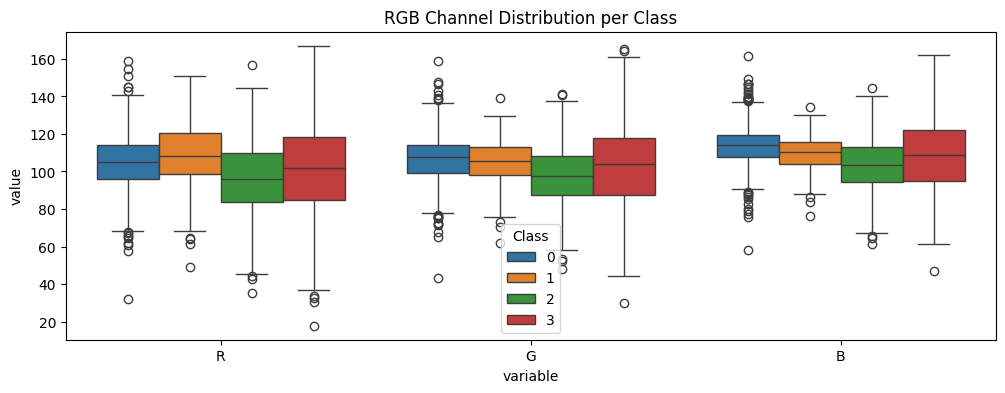

In [ ]:
plt.figure(figsize=(12,4))
sns.boxplot(data=df_color.melt(id_vars="Class"),
            x="variable", y="value", hue="Class")
plt.title("RGB Channel Distribution per Class")
plt.show()


# **Edge Density (Texture Strength)**

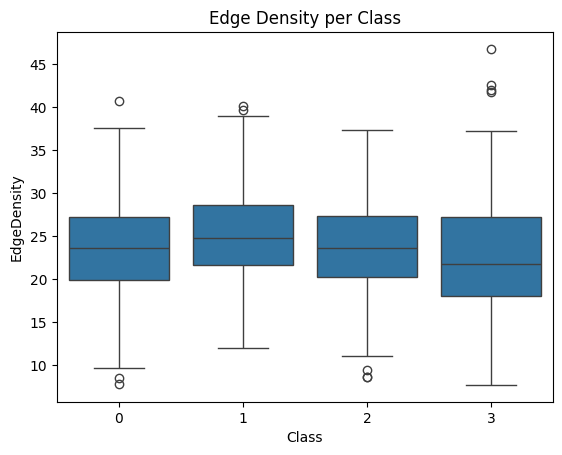

In [ ]:
def edge_density(split="train"):
    records = []

    for cls in sorted(os.listdir(os.path.join(DATASET_ROOT, split))):
        cls_dir = os.path.join(DATASET_ROOT, split, cls)
        for img in os.listdir(cls_dir):
            img_path = os.path.join(cls_dir, img)
            image = cv2.imread(img_path, 0)
            edges = cv2.Canny(image, 100, 200)
            density = edges.mean()
            records.append([cls, density])

    return pd.DataFrame(records, columns=["Class", "EdgeDensity"])

df_edges = edge_density("train")

sns.boxplot(x="Class", y="EdgeDensity", data=df_edges)
plt.title("Edge Density per Class")
plt.show()


# **Identify Hard / Ambiguous Images**

In [ ]:
df_stats["Brightness_z"] = (
    df_stats["Brightness"] - df_stats["Brightness"].mean()
) / df_stats["Brightness"].std()

df_stats.sort_values("Brightness_z").head(10)


Class  Brightness   Contrast  Brightness_z
1853     3   28.222046  27.499843     -4.451352
470      0   41.770813  29.685087     -3.654194
1711     3   41.900391  27.894703     -3.646570
1603     3   44.174011  29.025071     -3.512799
1634     3   45.054993  28.906644     -3.460965
1398     2   45.904480  27.747175     -3.410984
1777     3   48.714783  28.234667     -3.245637
1649     3   50.515015  34.627309     -3.139718
1361     2   50.951782  34.041271     -3.114020
1879     3   51.013733  32.388433     -3.110375